In [1]:
import pandas as pd
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pickle

from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Connecting to Google Drive and mount project to running instance

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Need to manually set project path.
fpath='/content/drive/MyDrive/Colab Notebooks/Capstone'

print(f"Project filepath, fpath: {fpath}")

file_path_censo = fpath+'/data/Comercial_Censo.csv'
file_path_metero = fpath+'/data/Comercial_Meteorología.csv'
file_path_test = fpath+'/data/Comercial_Test.csv'
file_path_ventas = fpath+'/data/Comercial_Ventas.csv'
file_path_ventas_test = fpath+'/data/Comercial_Test.csv'

data_censo = pd.read_csv(file_path_censo, delimiter=';', encoding='latin1', decimal=',',thousands='.')
data_meteoro = pd.read_csv(file_path_metero, delimiter=',', decimal=',', encoding='latin1',usecols=lambda column: column not in ['Unnamed: 0'])
data_test= pd.read_csv(file_path_test, delimiter=';', encoding='latin1')
data_ventas= pd.read_csv(file_path_ventas, delimiter=';', decimal=',', encoding='latin1')
data_ventas['sale_date']=pd.to_datetime(data_ventas['Dia'], dayfirst=True)

data_ventas_test=pd.read_csv(file_path_ventas_test, delimiter=';', decimal=',', encoding='latin1')
data_ventas_test['sale_date']=pd.to_datetime(data_ventas_test['Dia']) # not the same date format as Comercial_Ventas.csv!


Project filepath, fpath: /content/drive/MyDrive/Colab Notebooks/Capstone


In [7]:
df_flat_pvp=pd.read_pickle(fpath+'/data/df_flat_pvp.pkl')
df_flat_pvp_test=pd.read_pickle(fpath+'/data/df_flat_pvp_test.pkl')
df_flat=pd.read_pickle(fpath+'/data/df_flat.pkl')
df_flat_test=pd.read_pickle(fpath+'/data/df_flat_test.pkl')
df_res=pd.read_pickle(fpath+'/data/df_res_vanilla.pkl')
# df_res_test=pd.read_pickle(fpath+'/data/df_res_test.pkl')

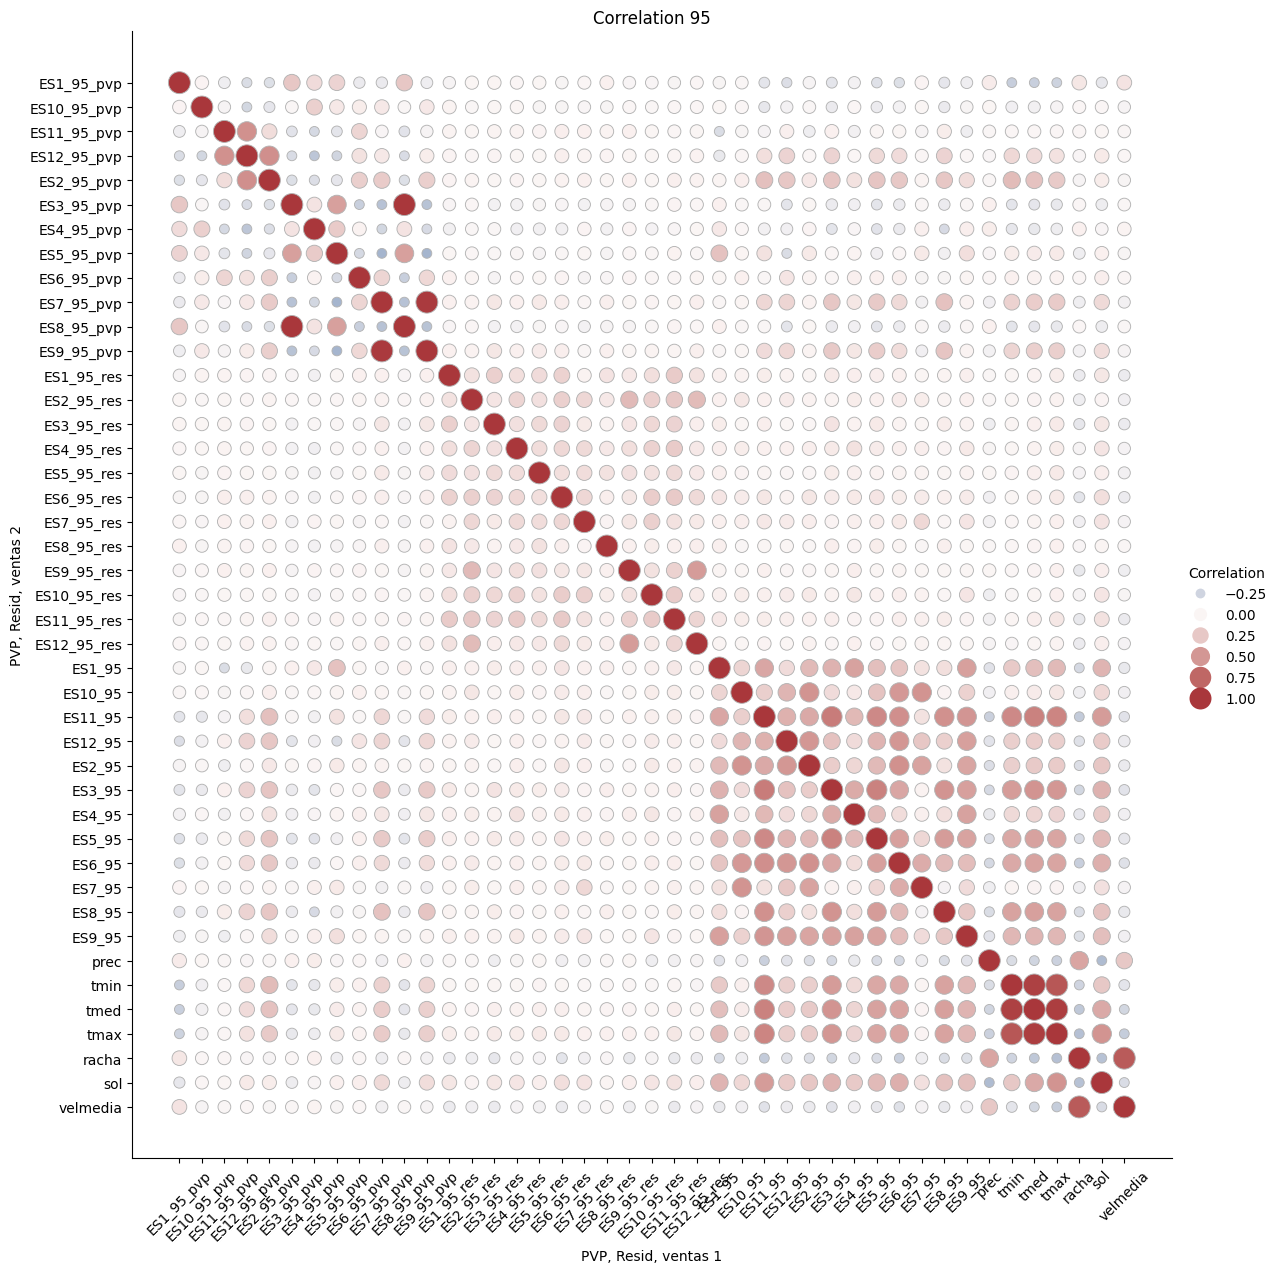

In [8]:

shift=1 #is data today related to residual tomorrow

df_diff_pvp95=df_flat_pvp.loc[:,[c for c in df_flat_pvp.columns if '95' in c and 'ES' in c]]-df_flat_pvp.loc[:,['MED_95']].values
df_diff_pvpGOA=df_flat_pvp.loc[:,[c for c in df_flat_pvp.columns if 'GOA' in c and 'ES' in c]]-df_flat_pvp.loc[:,['MED_GOA']].values

df_res95=df_res.loc[:,[c for c in df_res.columns if '95' in c and 'ES' in c]].shift(shift)
df_resGOA=df_res.loc[:,[c for c in df_res.columns if 'GOA' in c and 'ES' in c]].shift(shift)

df_flat95=df_flat.loc[:,[c for c in df_flat.columns if '95' in c and 'ES' in c]]
df_flatGOA=df_flat.loc[:,[c for c in df_flat.columns if 'GOA' in c and 'ES' in c]]


df_res_rel_95=df_res95.div(df_flat95,axis=1).shift(shift)
df_res_rel_GOA=df_resGOA.div(df_flatGOA,axis=1).shift(shift)


df_corr95=pd.merge(pd.merge(df_diff_pvp95,df_res95,how='inner',left_index=True,right_index=True,suffixes=('_pvp','_res')),df_flat95,how='inner',left_index=True,right_index=True)
df_corrGOA=pd.merge(pd.merge(df_diff_pvpGOA,df_resGOA,how='inner',left_index=True,right_index=True,suffixes=('_pvp','_res')),df_flatGOA,how='inner',left_index=True,right_index=True)


# The Ip code in prec means negligible precipitation, that is, an amount less than 0.1 mm.
# let's replace it with 0.05 mm and fix datatype of prec
if data_meteoro.prec.dtype!='float64':
    data_meteoro.prec=data_meteoro.prec.apply(lambda x: 0.05 if x=='Ip' else np.float64(x.replace(',','.')))
data_meteoro.head()

data_meteoro['sale_date']=pd.to_datetime(data_meteoro.fecha)
df_met=data_meteoro.set_index('sale_date').loc[:,['prec','tmin','tmed','tmax','racha','sol','velmedia']]

df_corr95=pd.merge(df_corr95,df_met,how='inner',left_index=True,right_index=True)
df_corrGOA=pd.merge(df_corrGOA,df_met,how='inner',left_index=True,right_index=True)


corr_mat = df_corr95.corr().stack().reset_index(name="correlation")
corr_mat.columns=['PVP, Resid, ventas 1','PVP, Resid, ventas 2','Correlation']

g95 = sns.relplot(
    data=corr_mat,
    x="PVP, Resid, ventas 1", y="PVP, Resid, ventas 2", hue="Correlation", size="Correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=12, sizes=(50, 250), size_norm=(-.2, .8),
)
g95.set_xticklabels(rotation=45)
plt.title('Correlation 95')

import pickle
datadict={'df_corr95':df_corr95,'df_corrGOA':df_corrGOA}

with open(fpath+'/data/df_corr.pkl', 'wb') as f:
    pickle.dump(datadict, f, pickle.HIGHEST_PROTOCOL)


Text(0.5, 1.0, 'Correlation GOA')

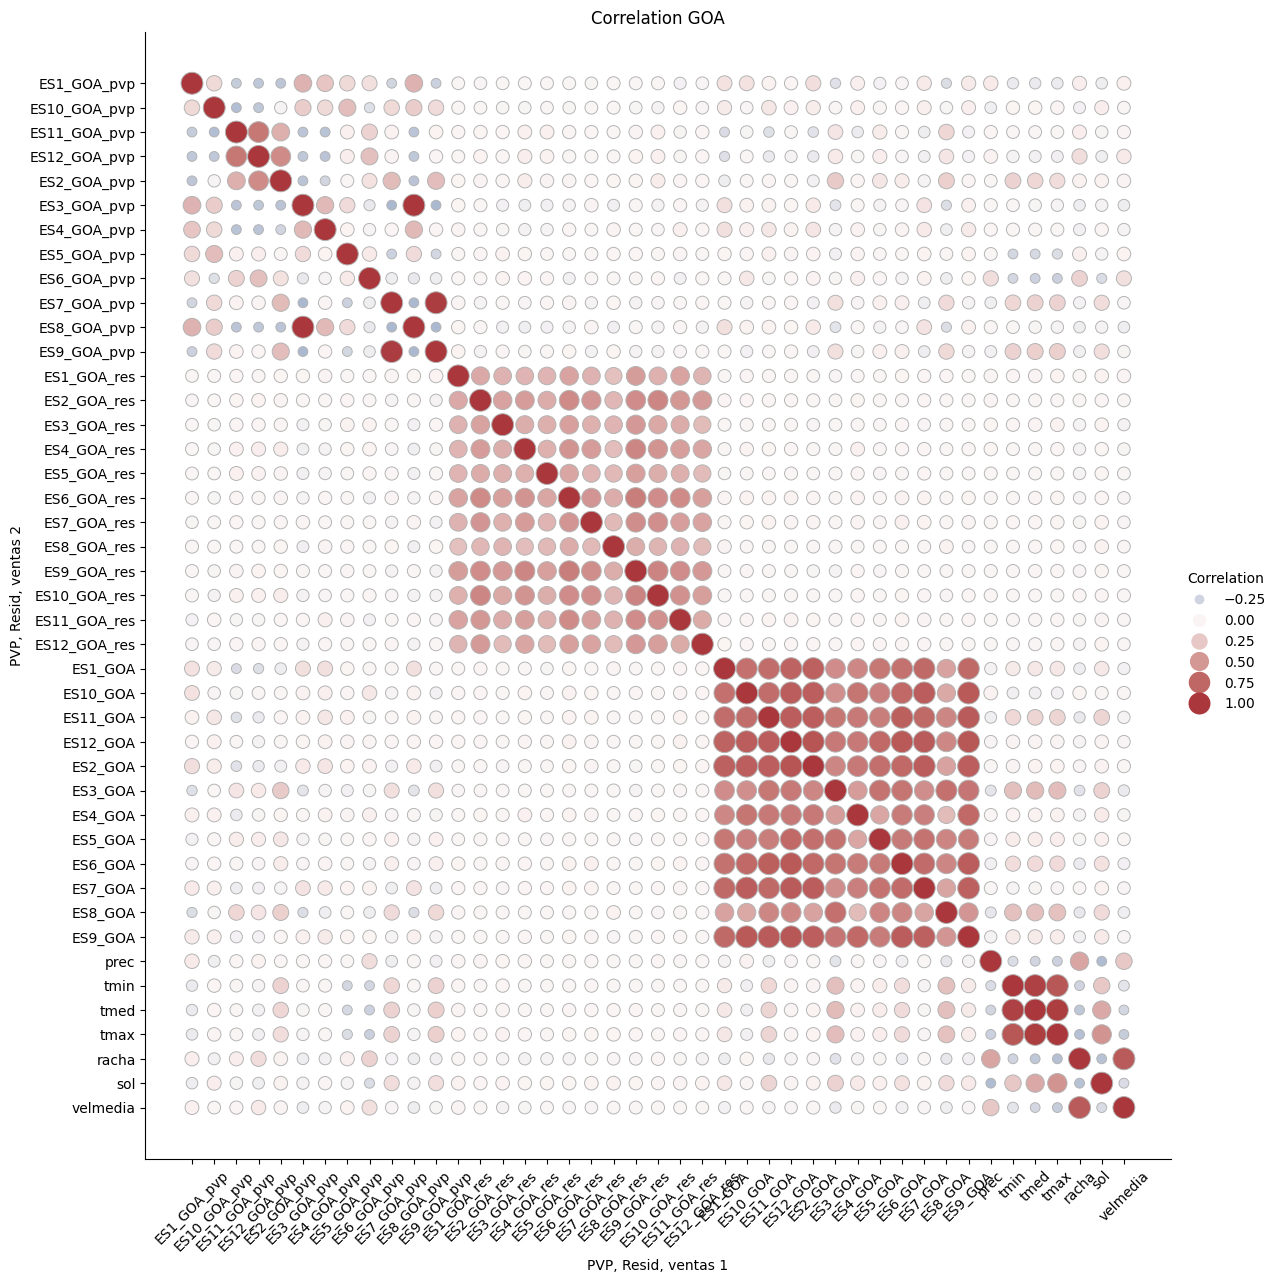

In [9]:

corr_mat = df_corrGOA.corr().stack().reset_index(name="correlation")
corr_mat.columns=['PVP, Resid, ventas 1','PVP, Resid, ventas 2','Correlation']

g = sns.relplot(
    data=corr_mat,
    x="PVP, Resid, ventas 1", y="PVP, Resid, ventas 2", hue="Correlation", size="Correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=12, sizes=(50, 250), size_norm=(-.2, .8),
)
g.set_xticklabels(rotation=45)
plt.title('Correlation GOA')


<Axes: >

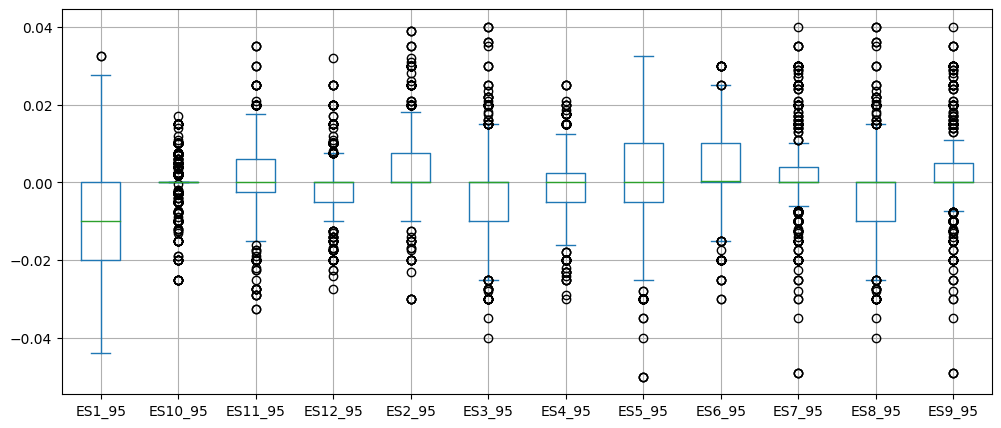

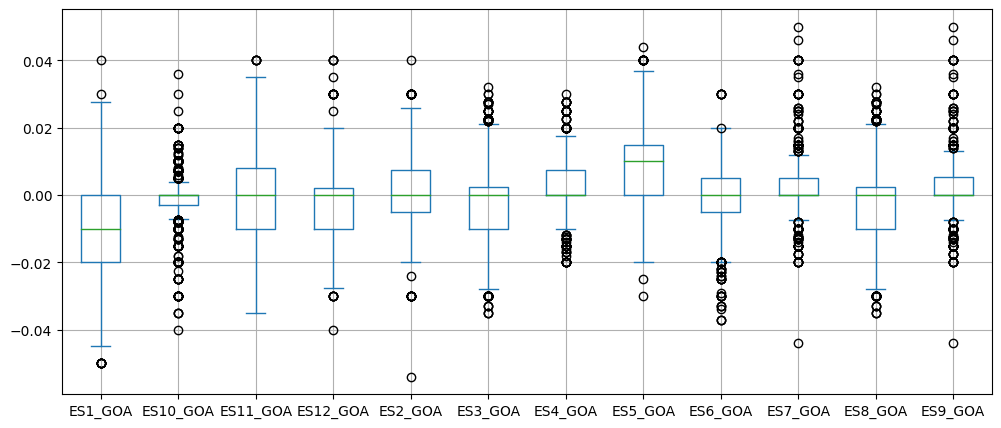

In [10]:
df_diff_pvp95.plot.box(figsize=(12,5),grid=True)
df_diff_pvpGOA.plot.box(figsize=(12,5),grid=True)

## Add weather data

In [11]:
data_meteoro.head()
# The Ip code in prec means negligible precipitation, that is, an amount less than 0.1 mm.
# let's replace it with 0.05 mm
if data_meteoro.prec.dtype!='float64':
    data_meteoro.prec=data_meteoro.prec.apply(lambda x: 0.05 if x=='Ip' else np.float64(x.replace(',','.')))
data_meteoro.head()

,altitud,dir,fecha,horaPresMax,horaPresMin,horaracha,horatmax,horatmin,indicativo,nombre,...,presMax,presMin,provincia,racha,sol,tmax,tmed,tmin,velmedia,sale_date
0,58,18,2016-01-01,00,11,10:50,13:10,23:59,1387,A CORUA,...,1012.5,998.3,A CORUA,19.4,1.8,15.3,12.4,9.4,5.8,2016-01-01
1,58,22,2016-01-02,11,24,01:20,14:30,06:20,1387,A CORUA,...,1014.3,1006.2,A CORUA,13.6,5.7,14.0,11.2,8.4,4.2,2016-01-02
2,58,25,2016-01-03,00,13,13:20,Varias,00:00,1387,A CORUA,...,1006.2,996.9,A CORUA,19.2,0.0,15.6,14.0,12.3,5.8,2016-01-03
3,58,29,2016-01-04,Varias,14,15:00,00:00,23:40,1387,A CORUA,...,999.9,994.5,A CORUA,17.8,0.0,13.0,11.0,9.1,6.7,2016-01-04
4,58,99,2016-01-05,23,06,Varias,13:50,11:00,1387,A CORUA,...,1006.2,998.6,A CORUA,21.4,1.9,11.2,9.5,7.8,10.8,2016-01-05


In [12]:

# merge with meteorological data
data_meteoro['sale_date']=pd.to_datetime(data_meteoro.fecha)

df_v_m=pd.merge(df_flat,data_meteoro.set_index('sale_date').loc[:,['prec','tmin','tmed','tmax','racha','sol','velmedia']],how='left',left_index=True,right_index=True)
df_v_m_test=pd.merge(df_flat_test,data_meteoro.set_index('sale_date').loc[:,['prec','tmin','tmed','tmax','racha','sol','velmedia']],how='left',left_index=True,right_index=True)

data={'df_v_m':df_v_m,'df_v_m_test':df_v_m_test}

with open(fpath+'/df_v_m2.pkl', 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

### Correlation between weather and sales volume

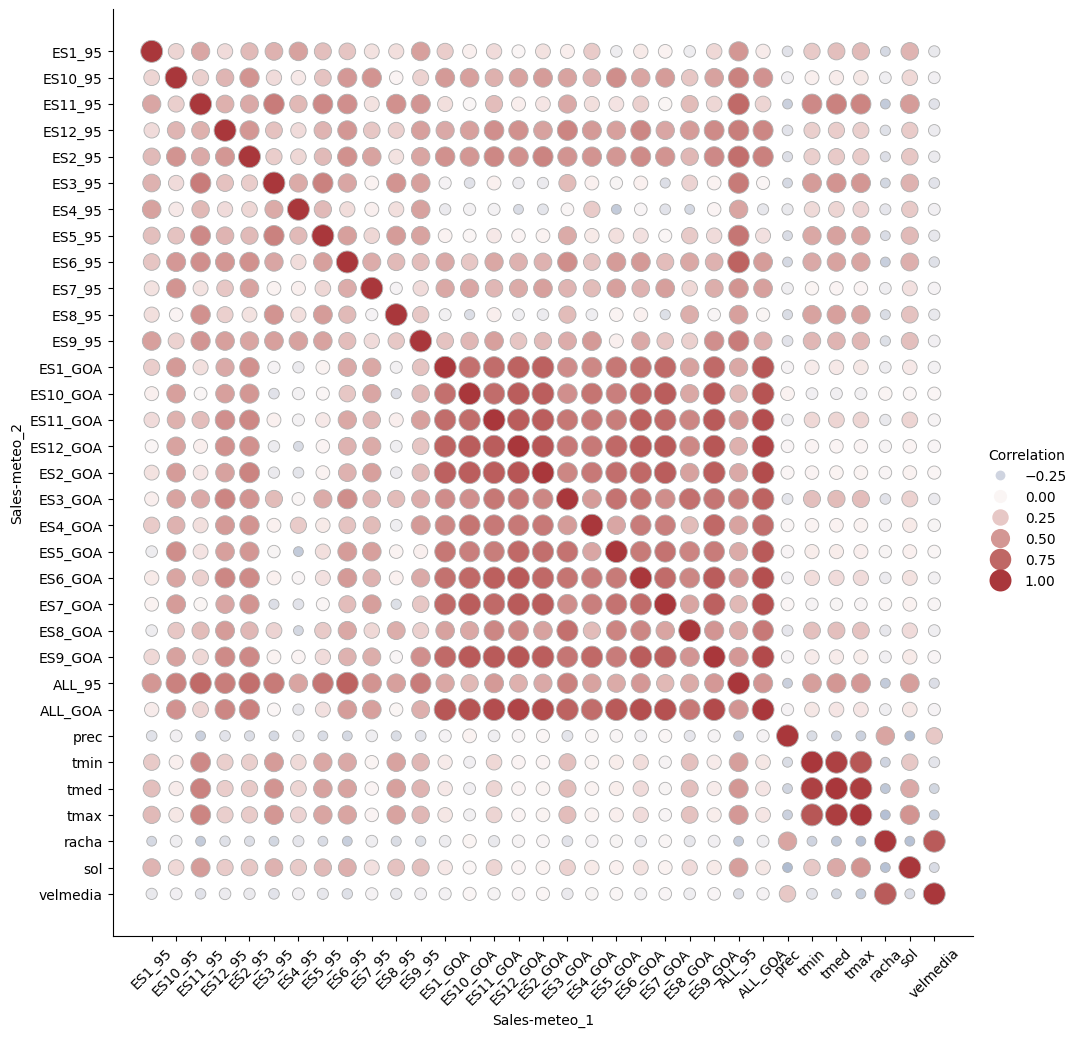

In [13]:
corr_mat = df_v_m.corr().stack().reset_index(name="correlation")
corr_mat.columns=['Sales-meteo_1','Sales-meteo_2','Correlation']

g = sns.relplot(
    data=corr_mat,
    x="Sales-meteo_1", y="Sales-meteo_2", hue="Correlation", size="Correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)
g.set_xticklabels(rotation=45)


### Sales outliers

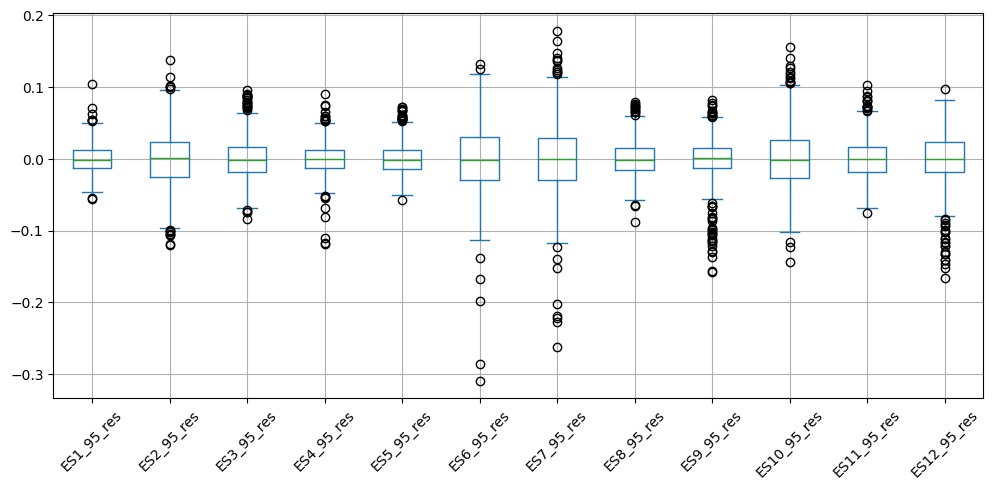

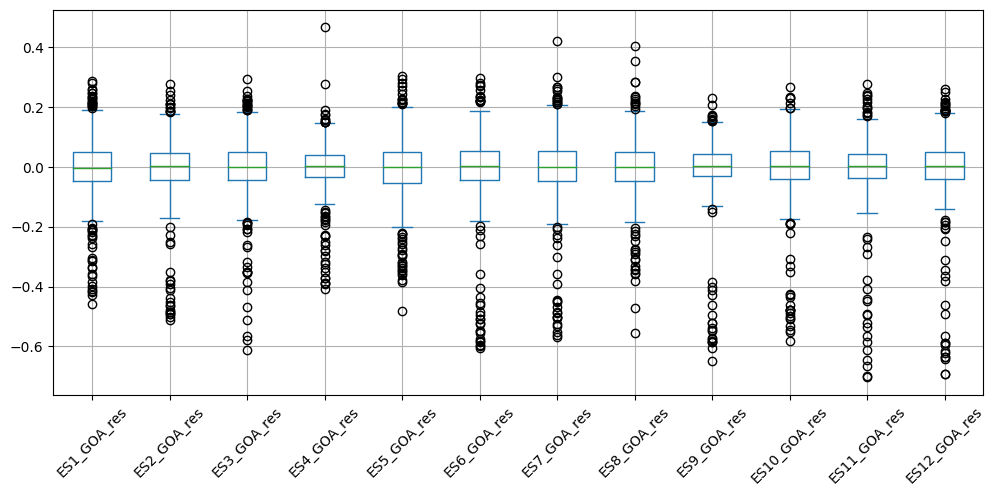

In [14]:
ax=df_corr95.loc[:,[f'ES{d}_95_res' for d in range(1,13)]].plot.box(figsize=(12,5),grid=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax=df_corrGOA.loc[:,[f'ES{d}_GOA_res' for d in range(1,13)]].plot.box(figsize=(12,5),grid=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
df_GOA=df_corrGOA.loc[:,[f'ES{d}_GOA' for d in range(1,13)]]

### GOA outliers

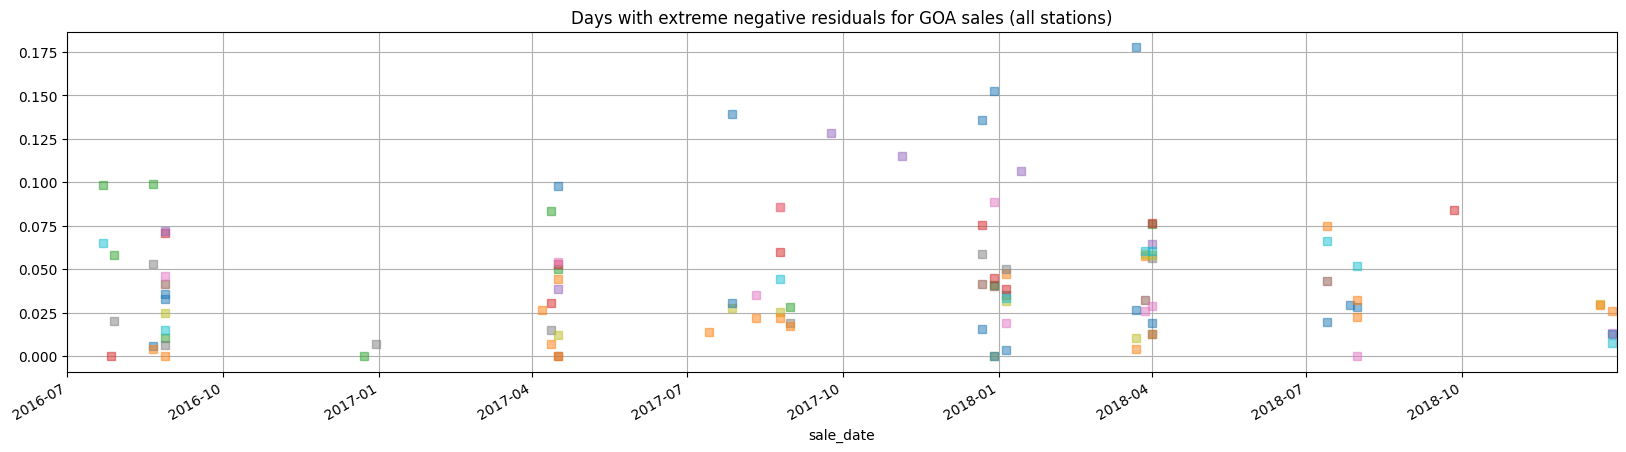

In [15]:
# Look for patterns in residual outliers, are there regular days with very low sales but not in holidays
# find days with extreme low sales for GOA (e.g. 1% quantile) and not holidays, i.e. potential extra holidays

qlim=0.01
qextra=df_GOA.quantile(qlim)

day_fiestas=data_ventas.groupby('sale_date').Fiesta.max()

dict_hol_extra={}
fig,ax=plt.subplots(1,1,figsize=(20,5))

for stn_GOA in [f"ES{d}_GOA" for d in range(1,13)]:

    qes=qextra[stn_GOA]
    filt= (df_GOA[stn_GOA]<qes) & (day_fiestas.isna())

    df_GOA.loc[filt,stn_GOA].plot(marker='s',alpha=0.5,lw=0,label=stn_GOA,ax=ax)

    dict_hol_extra[f"df_holi_extra_{stn_GOA}"]=pd.DataFrame({'ds':df_GOA.loc[filt,stn_GOA].index,'event':[f'Ev{d}' for d in df_GOA.loc[filt,stn_GOA].index.strftime('%m')]})

ax.set_xlim('2016-07-01','2018-12-31')
ax.grid('both')
ax.set_title(f'Days with extreme negative residuals for GOA sales (all stations)')

# see pattern around the New Year, Easter and in August, can add these as special holidays/events to training
# store these for each station
with open(fpath+'/data/df_holi_extra.pkl', 'wb') as f:
    pickle.dump(dict_hol_extra, f, pickle.HIGHEST_PROTOCOL)



### 95 Outliers

Text(0.5, 1.0, 'Days with extreme negative residuals 95 (all stations)')

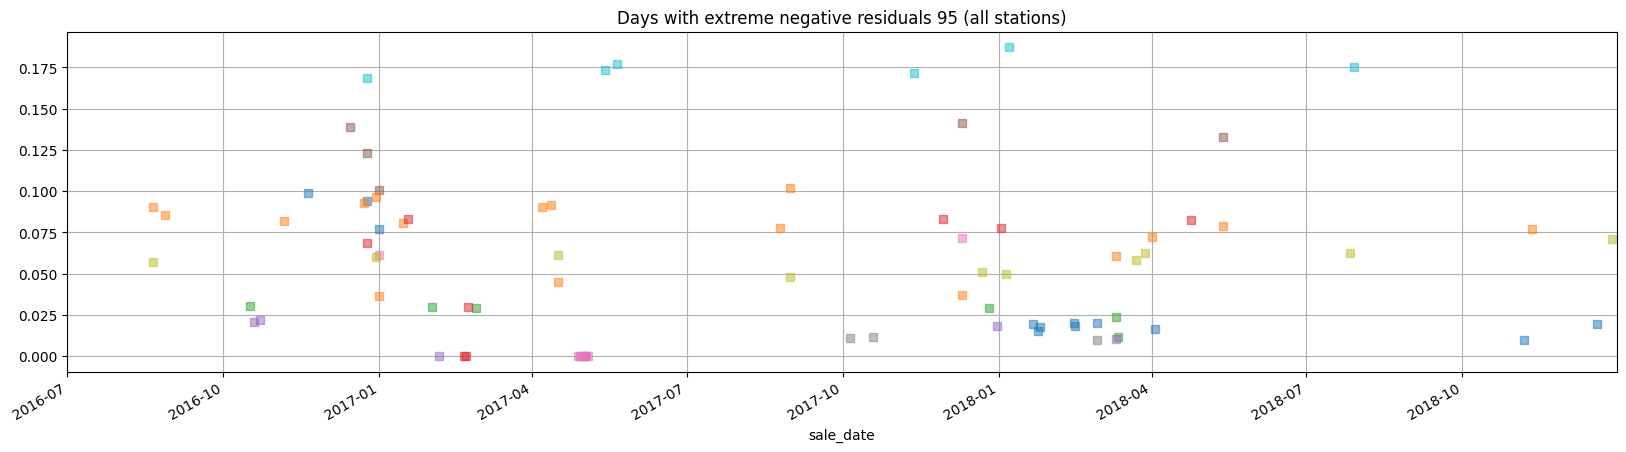

In [16]:

df_95=df_corr95.loc[:,[f'ES{d}_95' for d in range(1,13)]]

# find days with extreme low sales for 95 (e.g. 1% quantile) and not holidays, i.e. potential extra holidays

qlim=0.01
qextra=df_95.quantile(qlim)

day_fiestas=data_ventas.groupby('sale_date').Fiesta.max()

dict_hol_extra={}
fig,ax=plt.subplots(1,1,figsize=(20,5))

for stn_95 in [f"ES{d}_95" for d in range(1,13)]:

    qes=qextra[stn_95]
    filt= (df_95[stn_95]<qes) & (day_fiestas.isna())

    df_95.loc[filt,stn_95].plot(marker='s',alpha=0.5,lw=0,label=stn_95,ax=ax)

    dict_hol_extra[f"df_holi_extra_{stn_95}"]=pd.DataFrame({'ds':df_95.loc[filt,stn_95].index,'event':[f'Ev{d}' for d in df_95.loc[filt,stn_95].index.strftime('%m')]})

ax.set_xlim('2016-07-01','2018-12-31')
ax.grid('both')
ax.set_title(f'Days with extreme negative residuals 95 (all stations)')

# with open(fpath+'/df_holi_extra_95.pkl', 'wb') as f:
#     pickle.dump(dict_hol_extra, f, pickle.HIGHEST_PROTOCOL)
# plt.show()

# difficult to see patterns of dates with extreme low sales, therefore no extra holidays for 95